# Probability Threshold

Notebook that explores different probability thresholds. This is the threshold from what probability we count a pixel to be part of the signal.

In [1]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [4]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


In [5]:
N_examples = len(data_noisy)
print(f"Number of images: {N_examples}")

Number of images: 6400


**Data Preperation**

In [6]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((64*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min)/(pix_max-pix_min))

data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


In [7]:
# Batch form
batch_size = 1

N, H, W = data_noisy_train.shape
N_new = N//batch_size

data_noisy_train_batch = data_noisy_train[:int(N_new*batch_size)].reshape(N_new, batch_size, 1, H, W)
data_true_train_batch = data_true_train[:int(N_new*batch_size)].reshape(N_new, batch_size, H*W)

**The Autoencoder Model**

In [8]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

**Define functions for the training and the testing**

In [9]:
# Function to calculate the intersection-over-union
def IOU_calc(clean_iou, true_iou): 
    clean_sum = torch.sum(clean_iou)
    true_sum = torch.sum(true_iou)
    true_iou2 = torch.zeros(true_iou.shape)
    
    true_iou2[true_iou==0] = 2 
    true_iou2[true_iou==1] = 1
    
    intersection_arr = (clean_iou==true_iou2)
    intersection_sum = torch.sum(intersection_arr)
    
    IOU = intersection_sum/(clean_sum+true_sum-intersection_sum)
    
    return IOU

In [10]:
learning_rate = 0.0005

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [11]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train_batch, data_true_train_batch):
        #noisy = noisy.unsqueeze(0)
        #true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = torch.zeros((output_data.shape))
            output_binary[output_data>prob_threshold] = 1
            #output_binary = output_data.round()

            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

**Train the model**

In [12]:
%%time

n_epochs = 15

learning_rate = 0.0005

prob_threshold = 0.5

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.6789
IOU: 0.01871180720627308
Training set: Avg. loss: 0.1769

Test set: Avg. loss: 0.0902
IOU: 0.3591170608997345
Training set: Avg. loss: 0.1034

Test set: Avg. loss: 0.0797
IOU: 0.4452519416809082
Training set: Avg. loss: 0.0956

Test set: Avg. loss: 0.0798
IOU: 0.45391368865966797
Training set: Avg. loss: 0.0906

Test set: Avg. loss: 0.0857
IOU: 0.45694321393966675
Training set: Avg. loss: 0.0875

Test set: Avg. loss: 0.0725
IOU: 0.4862658381462097
Training set: Avg. loss: 0.0852

Test set: Avg. loss: 0.0717
IOU: 0.4833507537841797
Training set: Avg. loss: 0.0832

Test set: Avg. loss: 0.0735
IOU: 0.4851408004760742
Training set: Avg. loss: 0.0821

Test set: Avg. loss: 0.0810
IOU: 0.45891979336738586
Training set: Avg. loss: 0.0814

Test set: Avg. loss: 0.0713
IOU: 0.48864516615867615
Training set: Avg. loss: 0.0804

Test set: Avg. loss: 0.0702
IOU: 0.4911056160926819
Training set: Avg. loss: 0.0796

Test set: Avg. loss: 0.0705
IOU: 0.49070367217063904
Traini

**Using different probability thresholds**

In [13]:
prob_thresholds = np.arange(0,1.1,0.1)
IOU_thresholds = []
for prob_threshold in prob_thresholds:
    IOU=0
    for noisy, true in zip(data_noisy_test, data_true_test):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
            
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        
        output_data = F.sigmoid(output.data)
        output_binary = torch.zeros((output_data.shape))
        output_binary[output_data>=prob_threshold] = 1
        IOU += IOU_calc(output_binary, true)

    IOU /= len(data_noisy_test)
    IOU_thresholds.append(IOU)

IOU_arr = np.array(IOU_thresholds)

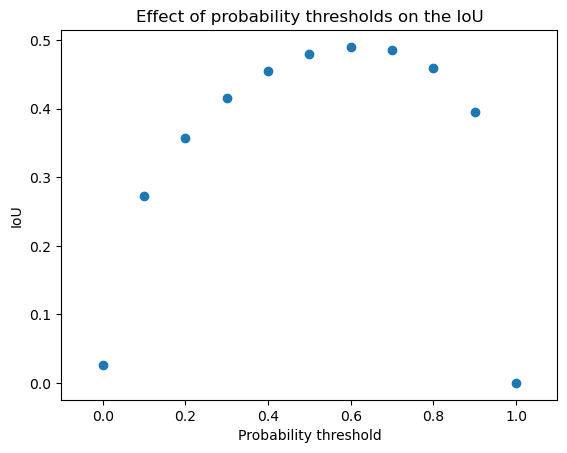

In [17]:
fig_prob_threshold = plt.figure()
plt.title("Effect of probability thresholds on the IoU")
plt.scatter(prob_thresholds, IOU_arr)
#plt.hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
plt.xlabel("Probability threshold")
plt.ylabel("IoU")
plt.xlim(-0.1, 1.1)
plt.show()

fig_prob_threshold.savefig("images/ProbThreshold.pdf")